# Bruco (Brute force coherence) Python Tutorial

Bruco is a tool for computing **"Brute force coherence"**. It calculates the coherence between the main channel (target) of gravitational wave detectors (LIGO or Virgo) and numerous auxiliary channels to identify noise sources.

#### Coherence Calculation with Parallel Processing

Parallel execution is performed across multiple CPU cores using Python's `multiprocessing` module.

1. **Task Division**: The entire auxiliary channel list is divided according to the number of CPUs and assigned to each process.
2. **Data Acquisition and Preprocessing**:
   * Acquire data for each auxiliary channel.
   * Skip if the data is constant (flat).
   * If the sampling rate is higher than the output request rate (`outfs`), downsample using the `decimate` function.
3. **Coherence Calculation**:
   * Calculate the FFT and PSD (Power Spectral Density) of the auxiliary channel.
   * Calculate the CSD (Cross Spectral Density) with the target channel.
   * Calculate the coherence using the following formula:
4. **Selection of Top N**:
   * For all frequency bins, if the calculated coherence value is higher than the existing top list (`top`), update the value. This efficiently records only the highly correlated top channels instead of keeping results for all channels.
5. **Result Aggregation and Output**:
   * Combine and sort `cohtab` (coherence values) and `idxtab` (channel IDs) returned from each process to create the final top list.
   * **HTML Report Generation**: Use `markup.py` to generate `index.html`. This includes tables of top correlated channels for each frequency (with heatmap-style coloring) and links to plot images.
   * **Plot Generation**: Use `matplotlib` to generate coherence and spectrum graphs (PNG or PDF).

This implementation is characterized by the use of **pre-computed FFTs**, **parallel processing**, and a **memory-efficient Top-N recording method** to efficiently process large amounts of channel data.

The original Bruco implementation is available at:
- https://github.com/mikelovskij/bruco

Refer to this for design details and CLI behavior.

This notebook demonstrates the advantages of using the `gwexpy` `Bruco` module **as a Python library** by showing interactive analysis, flexible data manipulation, and advanced hypothesis testing.

- We do not use real data, but instead utilize pseudo-data generated with `gwpy` / `numpy`.
- We demonstrate rapid hypothesis testing for "nonlinear coupling" and "modulation" scenarios that are difficult with the CLI, using the Python API.

## Setup and Mock Data Generation

**What we do**: Create pseudo-data for target/auxiliary channels and prepare `TimeSeries` to feed into Bruco.
**Why it's important**: In actual operations, data is acquired from NDS or frames, but being able to freely design signals in a notebook accelerates hypothesis testing.

In [1]:
# ruff: noqa: I001
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

from gwexpy.analysis import Bruco
from gwexpy.analysis.bruco import FastCoherenceEngine
from gwexpy.astro import inspiral_range
from gwexpy.frequencyseries import FrequencySeriesDict
from gwexpy.noise.asd import from_pygwinc
from gwexpy.noise.wave import from_asd
from gwexpy.plot import Plot
from gwexpy.timeseries import TimeSeries, TimeSeriesDict

/home/runner/miniconda3/envs/docs/lib/python3.11/site-packages/gwpy/time/_ligotimegps.py:42: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


AttributeError: module 'gwpy.io.registry' has no attribute 'register_reader'

In [2]:
rng = np.random.default_rng(7)

duration = 128  # seconds
sample_rate = 2048  # Hz
fftlength = 4.0  # seconds
overlap = 2.0  # seconds

t = np.arange(0, duration, 1 / sample_rate)

# Get aLIGO sensitivity curve (ASD)
fmax = sample_rate / 2  # Nyquist frequency
asd_aligo = from_pygwinc(
    "aLIGO", fmin=4.0, fmax=fmax, df=1.0 / duration, quantity="strain"
)

# Generate target noise based on aLIGO sensitivity curve
target = from_asd(asd_aligo, duration, sample_rate, t0=0, rng=rng).highpass(1)
target.channel = "H1:TARGET"

# Signals for auxiliary channels
fast_line = np.sin(2 * np.pi * 60.0 * t)
slow_motion = 70 * np.sin(2 * np.pi * 2.3 * t) + 30 * np.sin(2 * np.pi * 7.1 * t)

aux1_data = 0.8 * fast_line + 0.2 * rng.normal(0, 1.0, size=t.size)
aux2_data = 0.9 * slow_motion + 0.2 * rng.normal(0, 1.0, size=t.size) + 1
aux1 = TimeSeries(
    aux1_data, sample_rate=sample_rate, t0=0, unit="V", channel="H1:AUX1_FAST"
)
aux2 = TimeSeries(
    aux2_data, sample_rate=sample_rate, t0=0, unit="V", channel="H1:AUX2_SLOW"
).lowpass(30)

# Injection signal into target: aLIGO-based noise + linear coupling + nonlinear injection
target = target + 1e-22 * target.unit * (
    aux1 / u.V + aux2 / u.V + (aux1 / u.V / 2) ** 2 + 0.01 * (aux1 * aux2 / u.V**2)
)


target.name = target.channel
aux1.name = aux1.channel
aux2.name = aux2.channel

aux_dict = TimeSeriesDict(
    {
        aux1.channel: aux1,
        aux2.channel: aux2,
    }
)

print(f"aLIGO ASD at 100 Hz: {asd_aligo.crop(99, 101).value[0]:.2e} strain/sqrt(Hz)")
print(f"Target data std: {target.std():.2e}")

plot = Plot(
    [target.asd(8, 4), asd_aligo],
    aux1.asd(8, 4),
    aux2.asd(8, 4),
    figsize=(10, 12),
    sharex=True,
)
axes = plot.get_axes()
axes[0].set_xlim(1, 1e3)
axes[0].set_ylim(1e-24, 1e-19)
axes[1].set_ylim(1e-3, 1e1)
axes[2].set_ylim(1e-4, 1e3)
axes[0].legend([target.name, "Model ASD"])
axes[1].legend([aux1.name])
axes[2].legend([aux2.name])

NameError: name 'from_pygwinc' is not defined

## Section 1: Running Basic Bruco Analysis (Reproduction in Jupyter)

**What we do**: Run brute force coherence analysis with the `Bruco` class and verify results with tables and plots.
**Why it's important**: With the Python API, you can quickly try "culprit searches" while interactively changing conditions and visualizations.

In [3]:
# Initialize Bruco.
# Since we manually pass all data here, specify an empty list for auto-fetch channel list (aux_channels).
bruco = Bruco(target_channel=target.name, aux_channels=[])

# By passing target_data and aux_data to the compute method, you can skip internal fetching and run the analysis.
result = bruco.compute(
    start=0,
    duration=int(duration),
    fftlength=fftlength,
    overlap=overlap,
    nproc=1,
    batch_size=2,
    top_n=3,
    target_data=target,  # Pre-generated target data
    aux_data=aux_dict,  # Pre-generated auxiliary channel data dictionary
)

NameError: name 'Bruco' is not defined

In [4]:
df = result.to_dataframe(ranks=[0])

df_sorted = (
    df.sort_values("coherence", ascending=False)
    .dropna(subset=["channel"])
    .head(15)
    .reset_index(drop=True)
)

df_sorted

NameError: name 'result' is not defined

In [5]:
result.plot_projection(coherence_threshold=0.5)
plt.xlim(4, 1000)
plt.show()

result.plot_coherence(coherence_threshold=0.5)
plt.xlim(1, 1000)
plt.show()

NameError: name 'result' is not defined

In [6]:
report_path = result.generate_report("bruco_report", coherence_threshold=0.4)
report_path

NameError: name 'result' is not defined

## Section 2: Advanced Preprocessing and Hypothesis Testing (Deep Dive: Nonlinear & Bilinear)

**What we do**: Assume noise that cannot be explained by existing linear correlations and test hypotheses of nonlinear coupling (squared) and modulation (product).
**Why it's important**: Using `FastCoherenceEngine`, you can rapidly test virtual channels without recalculating the target FFT.

In [7]:
ts_sq = aux1**2
ts_sq.name = f"{aux1.name}^2"

ts_prod = aux1 * aux2
ts_prod.name = f"{aux1.name}*{aux2.name}"

NameError: name 'aux1' is not defined

In [8]:
engine = FastCoherenceEngine(target, fftlength=fftlength, overlap=overlap)

coh_linear = engine.compute_coherence(aux1)
coh_sq = engine.compute_coherence(ts_sq)
coh_prod = engine.compute_coherence(ts_prod)

freqs = engine.frequencies

NameError: name 'FastCoherenceEngine' is not defined

NameError: name 'freqs' is not defined

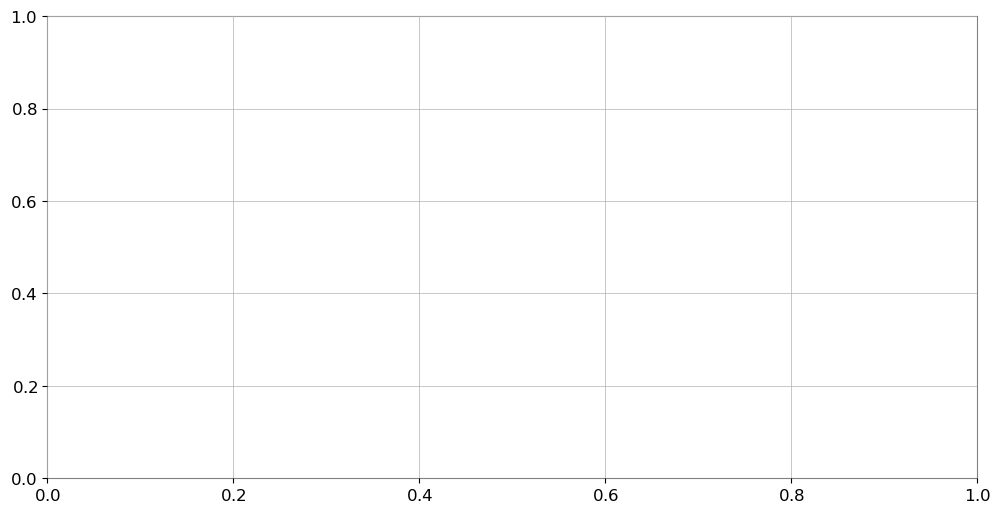

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.semilogx(freqs, coh_linear, label=f"Linear: {aux1.name}")
ax.semilogx(freqs, coh_sq, label=f"Squared: {ts_sq.name}")
ax.semilogx(freqs, coh_prod, label=f"Product: {ts_prod.name}")

ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Coherence")
ax.set_ylim(0.0, 1.0)
ax.grid(True, which="both", ls="-", alpha=0.4)
ax.legend()
plt.show()

## Section 3: Connection to Downstream Analysis (Actionable Outcome)

**What we do**: Use the most significant noise hypothesis to estimate the residual spectrum and assess BNS Range improvement.
**Why it's important**: Rather than stopping at "finding" Bruco results, we can connect them to sensitivity improvement and noise subtraction workflows.

In [10]:
target_asd = target.asd(fftlength=fftlength, overlap=overlap)
target_asd_vals = target_asd.value

coh_map = {
    aux1.name: coh_linear,
    ts_sq.name: coh_sq,
    ts_prod.name: coh_prod,
}

dominant_label = max(coh_map, key=lambda k: np.nanmax(coh_map[k]))
dominant_coh = coh_map[dominant_label]

# Estimate virtual channel contribution in ASD using Bruco's projection formula
projected_asd = target_asd_vals * np.sqrt(dominant_coh)
residual_asd_vals = np.sqrt(np.maximum(target_asd_vals**2 - projected_asd**2, 0.0))

residual_asd = target_asd.copy()
residual_asd.value[:] = residual_asd_vals

fig, ax = plt.subplots(figsize=(12, 6))
# ax.loglog(target_asd.frequencies.value, target_asd_vals, label="Target ASD")
# ax.loglog(target_asd.frequencies.value, residual_asd_vals, label="Residual ASD")
ax.loglog(target_asd, label="Target ASD")
ax.loglog(residual_asd, label="Residual ASD")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("ASD")
ax.grid(True, which="both", ls="-", alpha=0.4)
ax.legend()
plt.show()

# BNS Range comparison
bns_range_before = inspiral_range(target_asd**2, mass1=1.4, mass2=1.4, fmin=10)
bns_range_after = inspiral_range(residual_asd**2, mass1=1.4, mass2=1.4, fmin=10)

print(f"Dominant hypothesis: {dominant_label}")
print(f"BNS range (before): {bns_range_before.to_value(u.Mpc):.2f} Mpc")
print(f"BNS range (after):  {bns_range_after.to_value(u.Mpc):.2f} Mpc")

NameError: name 'target' is not defined

In [11]:
virtual_channels = {
    aux1.name: aux1,
    ts_sq.name: ts_sq,
    ts_prod.name: ts_prod,
}

culprit_channels = [dominant_label]
witnesses = TimeSeriesDict({name: virtual_channels[name] for name in culprit_channels})

cxx = witnesses.csd_matrix(fftlength=8.0)
cyx = TimeSeriesDict({"TARGET": target}).csd_matrix(other=witnesses, fftlength=8.0)

# Matrix operation H = Cyx @ Cxx^-1
H_lowres = cyx @ cxx.inv()

# Display estimated transfer function
H_lowres.abs().plot(xscale="log", yscale="log").suptitle("Estimated MIMO Coupling (H)")
plt.show()

# Full-resolution FFT


tsd = TimeSeriesDict({"MAIN": target, **witnesses})
aux_names = culprit_channels

tsd_fft = tsd.fft()
main_fft = tsd_fft["MAIN"]

# Filter interpolation and matrix operation
H = H_lowres.interpolate(main_fft.frequencies)
X_mat = FrequencySeriesDict({k: tsd_fft[k] for k in aux_names}).to_matrix()

# Projection and subtraction
Y_proj = (H @ X_mat)[0, 0]
cleaned_fft = main_fft - Y_proj

# To time domain
cleaned_ts = cleaned_fft.ifft()

NameError: name 'aux1' is not defined

NameError: name 'target' is not defined

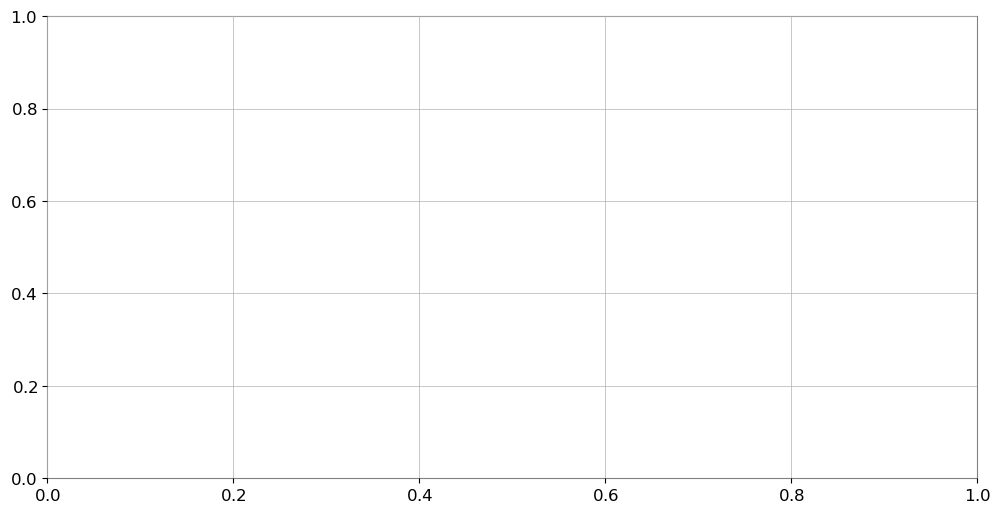

In [12]:
# Verify noise subtraction effect
fig = plt.figure(figsize=(12, 6))
ax = fig.gca()

# Overlay original and cleaned data (first 1 second)
plot_duration = 1.0
target.crop(end=target.t0.value + plot_duration).plot(
    ax=ax, label="Original", alpha=0.7
)  # noqa: F821
cleaned_ts.crop(end=target.t0.value + plot_duration).plot(
    ax=ax, label="Cleaned (Bruco)", linestyle="--", alpha=0.8
)  # noqa: F821

ax.set_title(f"Noise Subtraction Result (First {plot_duration}s)")
ax.legend()
plt.show()